HOUSE PRICE PREDICTION TEST - OPENHOUSE.AI

Kavya Bhojani

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sns.set(style="whitegrid")

In [ ]:
#loading dataset
df = pd.read_csv("dataset.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (1460, 22)
   LotArea  GrLivArea Street Alley  LotType BldgType HouseStyle  \
0     8910       1194   Pave   NaN   Corner     1Fam       1Fam   
1     1526        630   Pave   NaN   Inside    Twnhs     SFoyer   
2    14598       1933   Pave   NaN  CulDSac     1Fam     2Story   
3     7200       1040   Pave   NaN   Inside   Duplex     1Story   
4     5687       1716   Pave  Grvl   Inside   2fmCon     2Story   

   OverallQuality  OverallCondition  YearBuilt  ... CentralAir  FullBath  \
0               6                 6       1959  ...          Y         1   
1               4                 8       1970  ...          Y         1   
2               6                 5       2007  ...          Y         2   
3               4                 5       1949  ...          N         2   
4               5                 6       1912  ...          N         2   

  HalfBath  GarageType  GarageCars GarageArea  YearSold  SaleType  \
0        0     BuiltIn           2      539.0      20

DATA CLEANING

In [ ]:
#drop columns with excessive nulls
df.drop(columns=df.columns[df.isnull().mean() > 0.5], inplace=True)

#impute missing values
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])

#remove outliers
df = df[df['GrLivArea'] < 4500]
df = df[df['TotalBsmtSF'] < 3000]
df.drop(columns=['GarageArea'], inplace=True, errors='ignore')

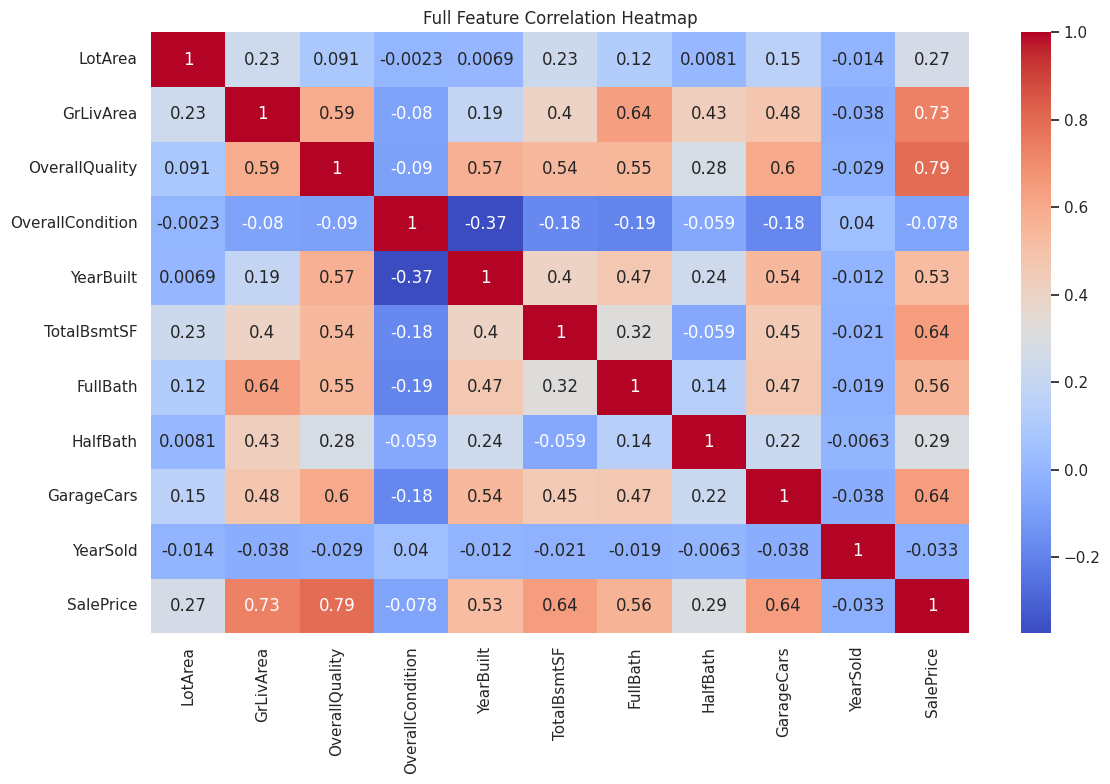

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Full Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

FEATURE ENGINEERING

In [ ]:
df['OverallQual_GrLivArea'] = df['OverallQuality'] * df['GrLivArea']
df['GarageCars_YearBuilt'] = df['GarageCars'] * df['YearBuilt']
df['Qual_Bsmt'] = df['OverallQuality'] * df['TotalBsmtSF']
df['Year_Overall'] = df['YearBuilt'] * df['OverallQuality']

TARGET ENCODING (rich categorical features)

In [ ]:
for col in ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish', 'SaleType']:
    if col in df.columns:
        mean_encoded = df.groupby(col)["SalePrice"].mean()
        df[f"{col}_enc"] = df[col].map(mean_encoded)
        df.drop(col, axis=1, inplace=True)

#encode remaining categoricals
df = pd.get_dummies(df, drop_first=True)

In [ ]:
#Log-transform target
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)
y_log = np.log1p(y)

#scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)
y_test_orig = np.expm1(y_test)

DEFINE MODELS

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.001),
    "XGBoost": XGBRegressor(
        n_estimators=600, max_depth=5, min_child_weight=1,
        subsample=0.9, colsample_bytree=0.7,
        learning_rate=0.03, random_state=42
    ),
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, random_state=42, verbosity=-1 )
}

FIT & EVALUATION

In [ ]:
predictions = {}
print("Model Results:")

for name, model in models.items():
    model.fit(X_train, y_train)

    pred = np.expm1(model.predict(X_test))
    predictions[name] = pred
    rmse = np.sqrt(mean_squared_error(y_test_orig, pred))
    r2 = r2_score(y_test_orig, pred)
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.4f}")

Model Results:
Linear Regression → RMSE: 22686.30, R²: 0.8879
Lasso Regression → RMSE: 22739.20, R²: 0.8873
XGBoost → RMSE: 22042.38, R²: 0.8941
LightGBM → RMSE: 22016.74, R²: 0.8944


WEIGHTED ENSEMBLE

In [ ]:
ensemble_pred = (
    0.15 * predictions["Linear Regression"] +
    0.2  * predictions["Lasso Regression"] +
    0.5  * predictions["XGBoost"] +
    0.15 * predictions["LightGBM"]
)

ensemble_rmse = np.sqrt(mean_squared_error(y_test_orig, ensemble_pred))
ensemble_r2 = r2_score(y_test_orig, ensemble_pred)
print(f"Ensemble → RMSE: {ensemble_rmse:.2f}, R²: {ensemble_r2:.4f}")

Ensemble → RMSE: 21280.93, R²: 0.9013


RESIDUAL PLOT

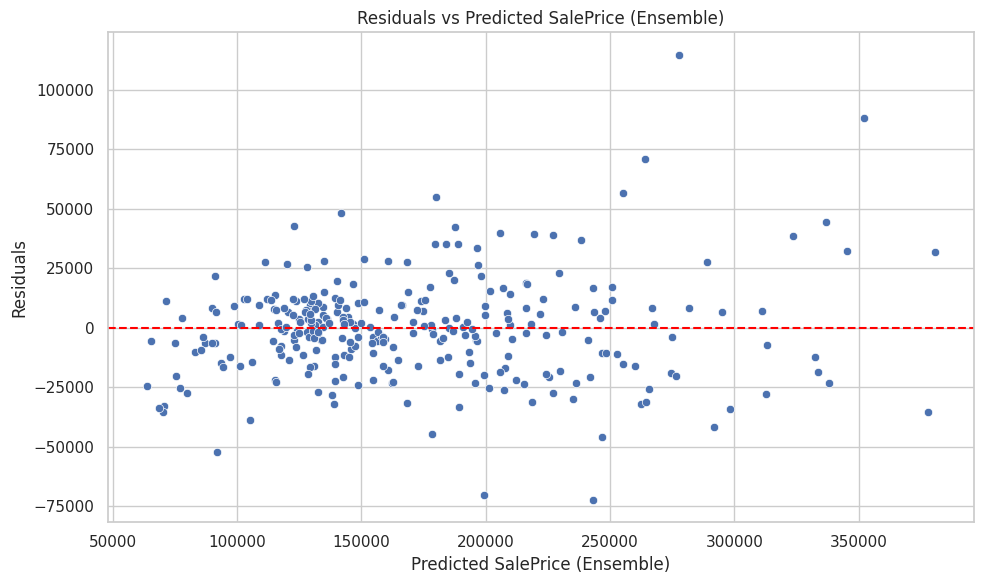

In [ ]:
residuals = y_test_orig - ensemble_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ensemble_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice (Ensemble)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted SalePrice (Ensemble)")
plt.tight_layout()
plt.show()

SAVING THE BEST MODEL - ENSEMBLE

In [ ]:
import numpy as np
import joblib

class CustomEnsembleModel:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def predict(self, X):
        preds = [np.expm1(model.predict(X)) for model in self.models]
        weighted_preds = sum(w * p for w, p in zip(self.weights, preds))
        return weighted_preds

#wrap trained models
ensemble_model = CustomEnsembleModel(
    models=[
        models["Linear Regression"],
        models["Lasso Regression"],
        models["XGBoost"],
        models["LightGBM"]
    ],
    weights=[0.15, 0.2, 0.5, 0.15]
)

#save the ensemble
joblib.dump(ensemble_model, "best_model_ensemble.pkl")
print("Ensemble model saved as 'best_model_ensemble.pkl'")

Ensemble model saved as 'best_model_ensemble.pkl'


In [53]:
# Save a template input row from training data
joblib.dump(X_train.iloc[0:1], "template_input_df.pkl")

['template_input_df.pkl']

In [55]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']